In [145]:
import sys
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import yaml

from models.point import Point, RefPoint
from models.map import Map
from models.pose import Pose
from utils.classify_points import classify_points
from utils.extract_track_borders import extract_track_borders
from utils.get_center_line import get_center_line
from utils.trajectory_from_points import trajectory_from_path
import math

from path_find_algorithms.A_star.A_star import AStar
import csv
from skimage import measure
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

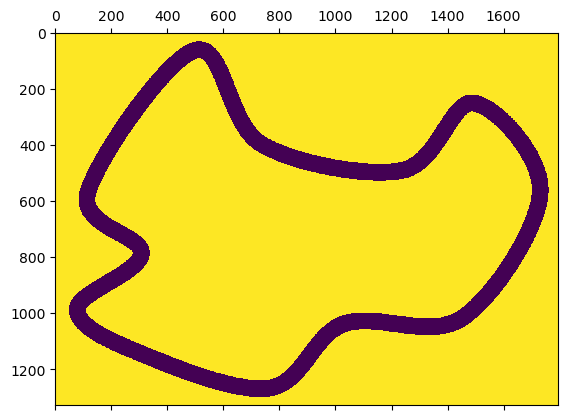

In [146]:
with open('../../../to_be_saved/tracks/track_3/costmap/map.npy', 'rb') as f:
    occupancy_grid = np.load(f)

with (open('../../../to_be_saved/tracks/track_3/costmap/map.yaml', 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

occupancy_grid = (occupancy_grid != 0) * 1

resolution = occupancy_grid_config["resolution"]
occupancy_map = Map(occupancy_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

plt.matshow(occupancy_map.grid)

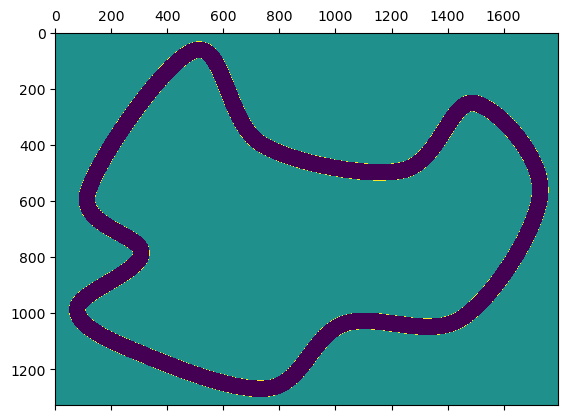

In [147]:
track_contours = measure.find_contours(occupancy_map.grid, 0)
assert len(track_contours) == 2

for contour in track_contours:
    y_coord = np.empty(contour.shape[0], dtype=int)
    x_coord = np.empty(contour.shape[0],  dtype=int)
    for i, element in enumerate(contour):
        y_coord[i] = element[0]
        x_coord[i] = element[1]
    occupancy_map.grid[y_coord, x_coord] = 2

plt.matshow(occupancy_map.grid)

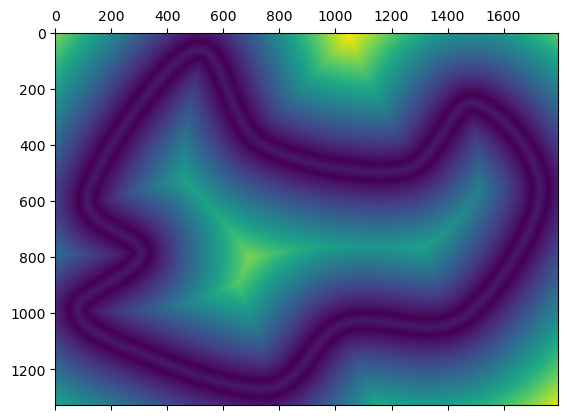

In [148]:
binarized_grid = occupancy_map.grid != 2
distances = ndimage.distance_transform_edt(binarized_grid)
plt.matshow(distances)

[0 1 2]


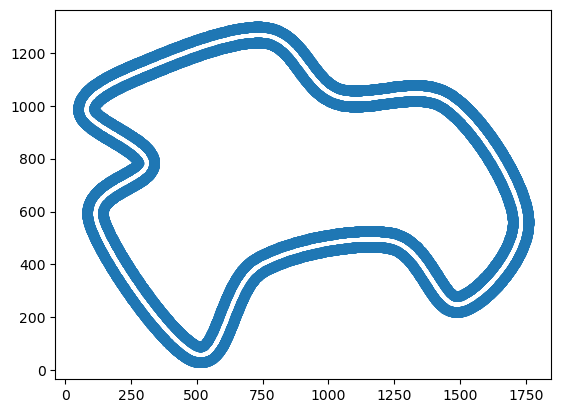

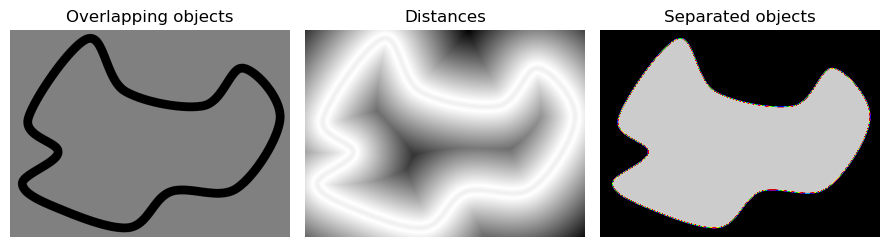

In [149]:
coords = peak_local_max(-distances, footprint=np.ones((3, 3)), labels=occupancy_map.grid)
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords])
mask = np.zeros(distances.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(distances, markers)
print(np.unique(occupancy_map.grid))

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(occupancy_map.grid, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distances, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

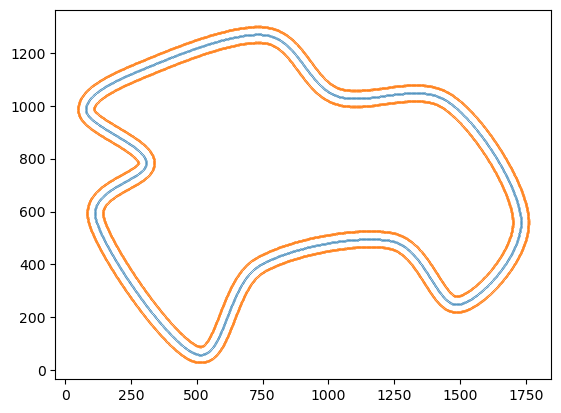

In [150]:
from skimage import measure
center_line = measure.find_contours(labels, 1)
assert len(center_line) == 1
center_line = center_line[0]
plt.scatter([coord[1] for coord in center_line], [coord[0] for coord in center_line], s=0.01)
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords], s=0.01)

In [151]:
distace_to_track_border = ndimage.distance_transform_edt(occupancy_map.grid == 0)

path = []
for coord in center_line:
    y,x = int(coord[0]), int(coord[1])
    distance = distace_to_track_border[y,x]
    path.append(RefPoint(y, x, distance, distance))

In [152]:
header = ['x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m']

with open('../../../to_be_saved/tracks/track_3/center_line.csv', 'w', encoding='UTF8', newline='') as f:
    path_world_coordinates = list(map(lambda point: occupancy_map.grid_point_to_world_point(
        point), path))
    
    header_str = "# "
    for word in header[:-1]:
        header_str += word +","
    header_str += header[-1]
    f.write(f"{header_str}\n")

    writer = csv.writer(f)
    path_world_coords_reformatted = list(map(lambda point: [point.x, point.y, point.w_tr_right, point.w_tr_left], path_world_coordinates))
    writer.writerows(path_world_coords_reformatted)

In [153]:

trajectory = trajectory_from_path(path, occupancy_map)
with open('../../../to_be_saved/trajectory.txt', 'w') as f:
    for pose in trajectory:
        f.write(f"{pose.coordinate.x},{pose.coordinate.y},{pose.quaternion.x},{pose.quaternion.y},{pose.quaternion.z},{pose.quaternion.w}\n")